# Vector data cubes

Exploration of possible implementation of vector data cubes in Python based on xarray and geopandas. The goal is to mimic what stars package in R can do - https://r-spatial.github.io/stars/articles/stars1.html#vector-data-cube-example

![vector data cube illustration](https://raw.githubusercontent.com/r-spatial/stars/master/images/cube3.png)

Because we need to use geometries as an index, we need to ensure that geopandas is using shapely 2.0 (beta) as a geometry engine. Shapely 1.8 geometries are not hashable, while shapely 2.0 are.

In [1]:
import geopandas
import pandas
import xarray
import numpy

We want to recreate [this example from stars documentation](https://r-spatial.github.io/stars/articles/stars1.html#vector-data-cube-example).

Load geometries using geopandas:

In [2]:
nc = geopandas.read_file("https://github.com/r-spatial/sf/raw/main/inst/gpkg/nc.gpkg")

Get the GeometryArray. Note that this also contains CRS information at this point.

In [3]:
origin = destination = nc.geometry.array

Create dimensions and dummy data.

In [4]:
mode = ["car", "bike", "foot"]
day = pandas.date_range("2015-01-01", periods=100)
hours = range(24)
data = numpy.random.randint(1, 100, size=(3, 100, 24, 100, 100))

Create `xarray.DataArray`.

In [5]:
arr = xarray.DataArray(data, coords=(mode, day, hours, origin, destination), dims=["mode", "day", "time", "origin", "destination"])
arr

<xarray.DataArray (mode: 3, day: 100, time: 24, origin: 100, destination: 100)>
array([[[[[35, 56, 46, ...,  6, 79, 35],
          [89,  5, 45, ..., 10, 23, 35],
          [64, 19, 74, ..., 73, 85,  4],
          ...,
          [30, 23, 52, ...,  3, 54, 69],
          [96, 63, 12, ..., 55, 93, 64],
          [64,  6, 80, ..., 27, 32, 53]],

         [[89, 11, 99, ..., 15, 38, 91],
          [ 3, 97, 36, ..., 95, 98, 82],
          [65, 71, 35, ...,  5, 80, 12],
          ...,
          [28, 33, 17, ..., 49, 19, 90],
          [85, 37, 11, ..., 86, 91, 52],
          [10, 32, 98, ...,  2, 22, 26]],

         [[71, 20, 71, ..., 20, 94, 15],
          [38, 67, 60, ..., 94, 85, 30],
          [66, 79, 37, ..., 47, 80,  5],
          ...,
...
          ...,
          [18, 31, 36, ..., 89, 74, 25],
          [33, 61, 48, ..., 66, 29, 65],
          [94, 22, 18, ...,  8, 17,  3]],

         [[10, 15, 91, ..., 54, 12, 28],
          [37,  3, 21, ..., 11, 17, 53],
          [48, 25, 50, ..., 77, 14, 16],
          ...,
          [35, 76, 83, ..., 15, 77, 61],
          [ 1, 93,  4, ..., 71, 29,  6],
          [40, 40, 24, ...,  7, 80, 56]],

         [[38, 36, 12, ..., 22, 58, 60],
          [71, 72, 88, ..., 22, 93, 56],
          [68, 88, 61, ..., 46, 32, 54],
          ...,
          [57, 92, 77, ..., 96, 19,  3],
          [77, 26, 76, ..., 45, 13, 72],
          [ 4, 66, 93, ..., 64, 24, 65]]]]])
Coordinates:
  * mode         (mode) <U4 'car' 'bike' 'foot'
  * day          (day) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-04-10
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * origin       (origin) object MULTIPOLYGON (((-81.4727554321289 36.2343559...
  * destination  (destination) object MULTIPOLYGON (((-81.4727554321289 36.23...

So far, all seems to work without hiccups out of the box.

Let's try some indexing. We can try to get counts for car on 2015-01-01 at noon from the first polygon to all the other. The resulting object should be a GeoDataFrame-like (one geometry column of all destinations and one data column of counts). 

In [6]:
s = arr.sel(mode="car", day='2015-01-01', time=12, origin=origin[0])
s

<xarray.DataArray (destination: 100)>
array([85, 66, 30, 37, 86,  3, 86, 54, 45, 89, 52, 61,  6, 38, 89, 66, 88,
       63, 17, 95, 87, 99, 35, 67, 97, 55, 38, 18, 79, 59, 46, 21, 10, 42,
       28, 35, 73, 10, 56, 23, 94, 87, 14, 66, 97, 69, 16, 95, 54, 54, 69,
       10, 53, 78, 48, 10, 32, 54, 36, 40, 61, 35, 50, 66, 32, 31, 31, 13,
       94, 73,  2, 64,  2, 19, 54, 30, 54, 12, 12, 70, 15, 39, 41, 81, 46,
       62, 50, 24, 29, 59, 95, 34, 17, 37, 64, 40, 88, 47, 63, 27])
Coordinates:
    mode         <U4 'car'
    day          datetime64[ns] 2015-01-01
    time         int64 12
    origin       object MULTIPOLYGON (((-81.4727554321289 36.23435592651367, ...
  * destination  (destination) object MULTIPOLYGON (((-81.4727554321289 36.23...

In [7]:
s.ndim

1

This would fail with shapely 1.8 but now we are fine. We have one dimensional DataArray indexed by an array of shapely polygons.

We can turn it into a GeoDataFrame and plot the result.

<AxesSubplot: >

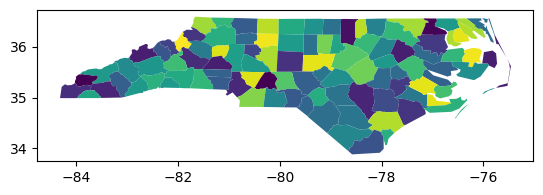

In [8]:
gdf = s.to_pandas().reset_index().set_geometry('destination')
gdf.plot(0)

The issue is that we have lost the CRS along the way. CRS is stored on a GeometryArray level but when we create DataArray, xarray uses only the underlying numpy array and ignores our custom attribute. 

In [9]:
gdf.crs is None

True

## What needs to be done

It seems that the it will not be very complex to implement convenient vector data cubes. We need to figure out:

- CRS handling
    - pyproj.CRS class storing the info on the GeometryArray level should be stored on a DataArray level as well (per dimension) and retained all the way back to a geopandas object.
    - It may require some custom logic during I/O and figuring out in which case we lose the info. Hopefully, most of it should be doable using xarray attrs. But some custom `to_geopandas` method may be needed as `to_pandas` still uses geometry as an index and that cannot contain CRS. So we need to convert to DataFrame/Series, reset index and create GeoDataFrame to which we pass a CRS stored on a DataArray level.
- Figure out which geometric ops need to be available on an xarray level
    - I have to check stars docs to see how the actual data cube interacts with the vector data apart from using them as an index.
- ... and probably more stuff I missed now.

## Wrap `shapely.STRtree` as an `xarray.indexes.Index`

Create a new `ShapelySTRTreeIndex` for using with Xarray Dataset and DataArray objects (note: this works only with the last release of Xarray 2022.11.0):

- It holds the CRS information, which must be provided explicitly. 
- It implements label-based data selection (`sel`) with two different modes:
  - "nearest" mode (default): selects the nearest geometry for each of the given input geometries
  - "query" mode: selects one or more geometries given a single input geometry and a predicate

Next steps:

- Figure out if we can leverage `shapely.STRtree`'s query capabilities for implementing custom alignment (spatial join) of Xarray Dataset / DataArray objects.
- `ShapelySTRTreeIndex` only supports 1-dimensional geometry coordinates, but we could probably make it work with n-d coordinates.
- It would be nice to automatically extract the CRS from the coordinate data. Unfortunately Xarray currently converts any geopandas.array.GeometryArray as a numpy array so we loose access to the CRS. I think this could be pretty easily fixed in Xarray.

In [10]:
import shapely
from xarray.indexes import Index
from xarray.core.indexes import IndexSelResult


class ShapelySTRTreeIndex(Index):
    
    def __init__(self, array, dim, crs):
        assert numpy.all(shapely.is_geometry(array))
        
        # only support 1-d coordinate for now
        assert len(array.shape) == 1
        
        self._tree = shapely.STRtree(numpy.ravel(array))
        self.dim = dim
        self.crs = crs
        
    @classmethod
    def from_variables(cls, variables, *, options):
        # only supports one coordinate of shapely geometries
        assert len(variables) == 1
        var = next(iter(variables.values()))

        return cls(var._data, var.dims[0], options["crs"])
    
    def sel(self, labels, method=None, tolerance=None):
        # We reuse here `method` and `tolerance` options of
        # `xarray.indexes.PandasIndex` as `predicate` and `distance`
        # options when `labels` is a single geometry.
        # Xarray currently doesn't support custom options
        # (see https://github.com/pydata/xarray/issues/7099)
        
        # only one coordinate supported
        assert len(labels) == 1
        label = next(iter(labels.values()))
        
        if method is not None and method != "nearest":
            if not isinstance(label, shapely.Geometry):
                raise ValueError(
                    "selection with another method than nearest only supports "
                    "a single geometry as input label."
                )

        if isinstance(label, xarray.DataArray):
            label_array = label._variable._data
        elif isinstance(label, xarray.Variable):
            label_array = label._data
        elif isinstance(label, shapely.Geometry):
            label_array = numpy.array([label])
        else:
            label_array = numpy.array(label)
        
        # check for possible CRS of geometry labels
        # (by default assume same CRS than the index)
        if hasattr(label_array, "crs") and label_array.crs != crs:
            raise ValueError("conflicting CRS for input geometries")
        
        assert numpy.all(shapely.is_geometry(label_array))
        
        if method is None or method == "nearest":
            indices = self._tree.nearest(label_array)
        else:
            indices = self._tree.query(label, predicate=method, distance=tolerance)

        # attach dimension names and/or coordinates to positional indexer
        if isinstance(label, xarray.Variable):
            indices = xarray.Variable(label.dims, indices)
        elif isinstance(label, xarray.DataArray):
            indices = xarray.DataArray(indices, coords=label._coords, dims=label.dims)

        return IndexSelResult({self.dim: indices})
   

Set two `ShapelySTRTreeIndex` instances for the `origin` and `destination` coordinates, respectively (first drop the two `pandas.Index` objects that were set by default for these two dimension coordinates).

In [11]:
arr = (
    arr
    .drop_indexes(["origin", "destination"])
    .set_xindex("origin", ShapelySTRTreeIndex, crs=origin.crs)
    .set_xindex("destination", ShapelySTRTreeIndex, crs=destination.crs)
)

arr

<xarray.DataArray (mode: 3, day: 100, time: 24, origin: 100, destination: 100)>
array([[[[[35, 56, 46, ...,  6, 79, 35],
          [89,  5, 45, ..., 10, 23, 35],
          [64, 19, 74, ..., 73, 85,  4],
          ...,
          [30, 23, 52, ...,  3, 54, 69],
          [96, 63, 12, ..., 55, 93, 64],
          [64,  6, 80, ..., 27, 32, 53]],

         [[89, 11, 99, ..., 15, 38, 91],
          [ 3, 97, 36, ..., 95, 98, 82],
          [65, 71, 35, ...,  5, 80, 12],
          ...,
          [28, 33, 17, ..., 49, 19, 90],
          [85, 37, 11, ..., 86, 91, 52],
          [10, 32, 98, ...,  2, 22, 26]],

         [[71, 20, 71, ..., 20, 94, 15],
          [38, 67, 60, ..., 94, 85, 30],
          [66, 79, 37, ..., 47, 80,  5],
          ...,
...
          ...,
          [18, 31, 36, ..., 89, 74, 25],
          [33, 61, 48, ..., 66, 29, 65],
          [94, 22, 18, ...,  8, 17,  3]],

         [[10, 15, 91, ..., 54, 12, 28],
          [37,  3, 21, ..., 11, 17, 53],
          [48, 25, 50, ..., 77, 14, 16],
          ...,
          [35, 76, 83, ..., 15, 77, 61],
          [ 1, 93,  4, ..., 71, 29,  6],
          [40, 40, 24, ...,  7, 80, 56]],

         [[38, 36, 12, ..., 22, 58, 60],
          [71, 72, 88, ..., 22, 93, 56],
          [68, 88, 61, ..., 46, 32, 54],
          ...,
          [57, 92, 77, ..., 96, 19,  3],
          [77, 26, 76, ..., 45, 13, 72],
          [ 4, 66, 93, ..., 64, 24, 65]]]]])
Coordinates:
  * mode         (mode) <U4 'car' 'bike' 'foot'
  * day          (day) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-04-10
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * origin       (origin) object MULTIPOLYGON (((-81.4727554321289 36.2343559...
  * destination  (destination) object MULTIPOLYGON (((-81.4727554321289 36.23...
Indexes:
    origin       ShapelySTRTreeIndex
    destination  ShapelySTRTreeIndex

In [12]:
arr.xindexes

Indexes:
    mode         PandasIndex
    day          PandasIndex
    time         PandasIndex
    origin       ShapelySTRTreeIndex
    destination  ShapelySTRTreeIndex

Access to the CRS via the index:

In [13]:
arr.xindexes["origin"].crs.to_string()

'EPSG:4267'

Default data selection using the "nearest" mode.

Note: no `ShapelySTRTreeIndex` is built from the selected geometries, i.e., `origin` and `destination` have no index in the output `DataArray`.

In [14]:
arr.sel(
    day="2015-01-01",
    time=0,
    origin=[shapely.Point(-80, 35), shapely.Point(-76, 35.6)],
    destination=[shapely.Point(-81, 36), shapely.Point(-77, 35.5)],
)

<xarray.DataArray (mode: 3, origin: 2, destination: 2)>
array([[[43, 51],
        [83, 38]],

       [[37, 61],
        [16, 22]],

       [[87, 19],
        [37, 36]]])
Coordinates:
  * mode         (mode) <U4 'car' 'bike' 'foot'
    day          datetime64[ns] 2015-01-01
    time         int64 0
    origin       (origin) object MULTIPOLYGON (((-79.91995239257812 34.807918...
    destination  (destination) object MULTIPOLYGON (((-80.72651672363281 35.5...

Alternative data selection using the "query" mode with a single geometry and a given predicate:

In [15]:
arr.sel(origin=shapely.box(-80, 35, -77, 38), method="intersects")

<xarray.DataArray (mode: 3, day: 100, time: 24, origin: 41, destination: 100)>
array([[[[[88, 26, 19, ..., 19, 63, 33],
          [77, 97, 29, ..., 36,  8, 63],
          [21,  8, 10, ..., 53, 53, 89],
          ...,
          [76, 53, 77, ..., 42, 10, 18],
          [55, 16, 93, ..., 78,  8, 37],
          [84, 84, 88, ..., 84, 65,  4]],

         [[99, 13, 41, ..., 20, 94, 92],
          [67, 23, 68, ..., 95, 57, 69],
          [28, 53, 99, ..., 22,  4, 81],
          ...,
          [94, 48, 16, ..., 22, 16, 92],
          [57, 60, 49, ..., 12, 48, 24],
          [20,  7, 88, ..., 89, 21,  1]],

         [[91, 53, 73, ..., 66, 59, 25],
          [52, 96, 39, ..., 14, 97, 48],
          [ 3, 90, 26, ..., 39, 20, 56],
          ...,
...
          ...,
          [81, 12, 92, ..., 88, 64, 90],
          [97, 77, 62, ..., 35, 72, 48],
          [69, 19, 94, ..., 44, 23, 43]],

         [[89, 58, 43, ..., 94, 28, 94],
          [67, 78, 14, ..., 29, 24, 37],
          [ 1, 33, 15, ..., 96, 76, 40],
          ...,
          [20, 81, 87, ..., 27, 62, 51],
          [29, 11, 93, ..., 41, 34, 76],
          [20, 24, 18, ..., 56, 11, 52]],

         [[62, 50, 43, ..., 92,  5, 23],
          [74, 22, 77, ..., 12, 52, 86],
          [96,  4, 47, ..., 87, 74, 25],
          ...,
          [19, 26, 15, ..., 93, 84, 94],
          [29, 93,  7, ..., 41, 89, 47],
          [43, 52, 79, ..., 18, 37, 35]]]]])
Coordinates:
  * mode         (mode) <U4 'car' 'bike' 'foot'
  * day          (day) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-04-10
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
    origin       (origin) object MULTIPOLYGON (((-78.11376953125 34.720985412...
  * destination  (destination) object MULTIPOLYGON (((-81.4727554321289 36.23...
Indexes:
    destination  ShapelySTRTreeIndex

An example of Xarray advanced indexing:

In [16]:
points = xarray.DataArray([shapely.Point(-80, 35), shapely.Point(-76, 35.6)], dims="points")

arr.sel(origin=points)

<xarray.DataArray (mode: 3, day: 100, time: 24, points: 2, destination: 100)>
array([[[[[13, 61,  7, ..., 45, 83, 86],
          [21, 56, 21, ..., 10, 86, 94]],

         [[79, 71, 90, ..., 61, 14, 64],
          [95, 63, 57, ..., 78,  3, 59]],

         [[24,  1, 15, ..., 83, 43, 97],
          [48, 21, 84, ..., 47, 41, 42]],

         ...,

         [[64, 84,  4, ..., 26, 97, 49],
          [32, 25, 17, ..., 96, 16, 74]],

         [[66, 51, 55, ..., 89, 40, 48],
          [17, 51, 19, ..., 14, 94, 58]],

         [[83, 97, 86, ..., 64, 74, 88],
          [29, 63, 63, ..., 85, 86, 30]]],

...

        [[[32, 43, 89, ..., 99, 21, 52],
          [76, 18, 26, ..., 10,  7,  8]],

         [[56, 48, 34, ..., 22, 64, 84],
          [62, 31, 59, ..., 75,  1, 42]],

         [[76, 37, 32, ..., 50, 77, 57],
          [11,  3, 85, ..., 86, 19,  3]],

         ...,

         [[76, 15, 85, ..., 25, 69, 56],
          [33, 39, 23, ..., 77, 74,  2]],

         [[26, 82, 76, ..., 96, 17, 22],
          [87, 55, 94, ..., 96, 19, 28]],

         [[59, 41,  5, ..., 29, 53, 63],
          [50, 38, 17, ..., 99, 43, 54]]]]])
Coordinates:
  * mode         (mode) <U4 'car' 'bike' 'foot'
  * day          (day) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-04-10
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
    origin       (points) object MULTIPOLYGON (((-79.91995239257812 34.807918...
  * destination  (destination) object MULTIPOLYGON (((-81.4727554321289 36.23...
Dimensions without coordinates: points
Indexes:
    destination  ShapelySTRTreeIndex

"Query" mode selection with an array-like of geometries is not supported:

In [17]:
arr.sel(origin=[shapely.Point(-80, 35), shapely.Point(-76, 35.6)], method="intersects")

ValueError: selection with another method than nearest only supports a single geometry as input label.